In [1]:
#
# For licensing see accompanying LICENSE file.
# Copyright (C) 2020 Apple Inc. All Rights Reserved.
#

import dataclasses
import pandas as pd

df = pd.read_feather("examples/endomondo.feather")
df_tmp = df[df["subject_idx"] < 15]  # to select only 15 users for faster training

In [2]:
from ode.data import WorkoutDataset, WorkoutDatasetConfig, make_dataloaders

data_config_train = WorkoutDatasetConfig(
    subject_id_column = "userId",
    workout_id_column = "id",
    time_since_start_column ='time_grid',
    time_of_start_column = 'start_dt',
    heart_rate_column = 'heart_rate',
    heart_rate_normalized_column = 'heart_rate_normalized',
    activity_columns = ["speed_h", "speed_v"],
    weather_columns = [],
    history_max_length=512,   
)
data_config_test = dataclasses.replace(data_config_train, chunk_size=None, stride=None)

train_dataset = WorkoutDataset(df_tmp[df_tmp["in_train"]], data_config_train)
test_dataset = WorkoutDataset(df_tmp, data_config_test)

train_dataloader, test_dataloader = make_dataloaders(train_dataset, test_dataset, batch_size=128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 16349.68it/s]


In [3]:
from ode.ode import ODEModel, OdeConfig
from ode.trainer import train_ode_model

ode_config = OdeConfig(
    data_config_train,
    learning_rate=1e-3,
    seed=0,
    n_epochs=10,
    encoder_embedding_dim=8,
    subject_embedding_dim=4,
    
)

model = ODEModel(
        workouts_info=df_tmp[["userId", "id"]],
        config=ode_config,
    
    )
model

ODEModel(
  (ode_parameter_functions): ModuleDict(
    (A): PersonalizedScalarNN(
      (dense_nn): DenseNN(
        (layers): ModuleList(
          (0): Linear(in_features=12, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=8, bias=True)
          (2): Linear(in_features=8, out_features=1, bias=True)
        )
        (f): Softplus(beta=1, threshold=20)
      )
    )
    (B): PersonalizedScalarNN(
      (dense_nn): DenseNN(
        (layers): ModuleList(
          (0): Linear(in_features=12, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=8, bias=True)
          (2): Linear(in_features=8, out_features=1, bias=True)
        )
        (f): Softplus(beta=1, threshold=20)
      )
    )
    (alpha): PersonalizedScalarNN(
      (dense_nn): DenseNN(
        (layers): ModuleList(
          (0): Linear(in_features=12, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=8, bias=True)
          (2): Linear(in

In [4]:
train_workout_ids = set(df_tmp[df_tmp["in_train"]]["id"].values)
res = train_ode_model(model, train_dataloader, test_dataloader, train_workout_ids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 8778.41it/s]


Epoch 0 took 33.3 seconds
Train mean l1: 9.566 bpm (= 6.924 %)
Test mean l1: 9.533 bpm (= 7.029 %)
Test mean l1-after2min: 9.046 bpm (= 6.535 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 8780.30it/s]


Epoch 1 took 32.9 seconds
Train mean l1: 9.105 bpm (= 6.583 %)
Test mean l1: 9.028 bpm (= 6.617 %)
Test mean l1-after2min: 8.573 bpm (= 6.160 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 8782.73it/s]


Epoch 2 took 33.0 seconds
Train mean l1: 8.592 bpm (= 6.154 %)
Test mean l1: 8.187 bpm (= 5.974 %)
Test mean l1-after2min: 7.739 bpm (= 5.521 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 9073.83it/s]


Epoch 3 took 32.9 seconds
Train mean l1: 8.800 bpm (= 6.270 %)
Test mean l1: 8.299 bpm (= 6.058 %)
Test mean l1-after2min: 7.834 bpm (= 5.585 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 8891.48it/s]


Epoch 4 took 33.0 seconds
Train mean l1: 8.678 bpm (= 6.130 %)
Test mean l1: 8.928 bpm (= 6.453 %)
Test mean l1-after2min: 8.551 bpm (= 6.061 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 8473.89it/s]


Epoch 5 took 34.4 seconds
Train mean l1: 8.533 bpm (= 6.129 %)
Test mean l1: 8.635 bpm (= 6.319 %)
Test mean l1-after2min: 8.149 bpm (= 5.832 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 9061.64it/s]


Epoch 6 took 33.0 seconds
Train mean l1: 8.688 bpm (= 6.289 %)
Test mean l1: 8.483 bpm (= 6.253 %)
Test mean l1-after2min: 8.021 bpm (= 5.792 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 8664.96it/s]


Epoch 7 took 33.1 seconds
Train mean l1: 8.498 bpm (= 5.931 %)
Test mean l1: 8.108 bpm (= 5.813 %)
Test mean l1-after2min: 7.686 bpm (= 5.381 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 9129.42it/s]


Epoch 8 took 32.8 seconds
Train mean l1: 8.057 bpm (= 5.843 %)
Test mean l1: 7.757 bpm (= 5.714 %)
Test mean l1-after2min: 7.254 bpm (= 5.215 %)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1269/1269 [00:00<00:00, 8779.59it/s]

Epoch 9 took 35.8 seconds
Train mean l1: 8.213 bpm (= 5.821 %)
Test mean l1: 8.305 bpm (= 5.999 %)
Test mean l1-after2min: 7.891 bpm (= 5.577 %)


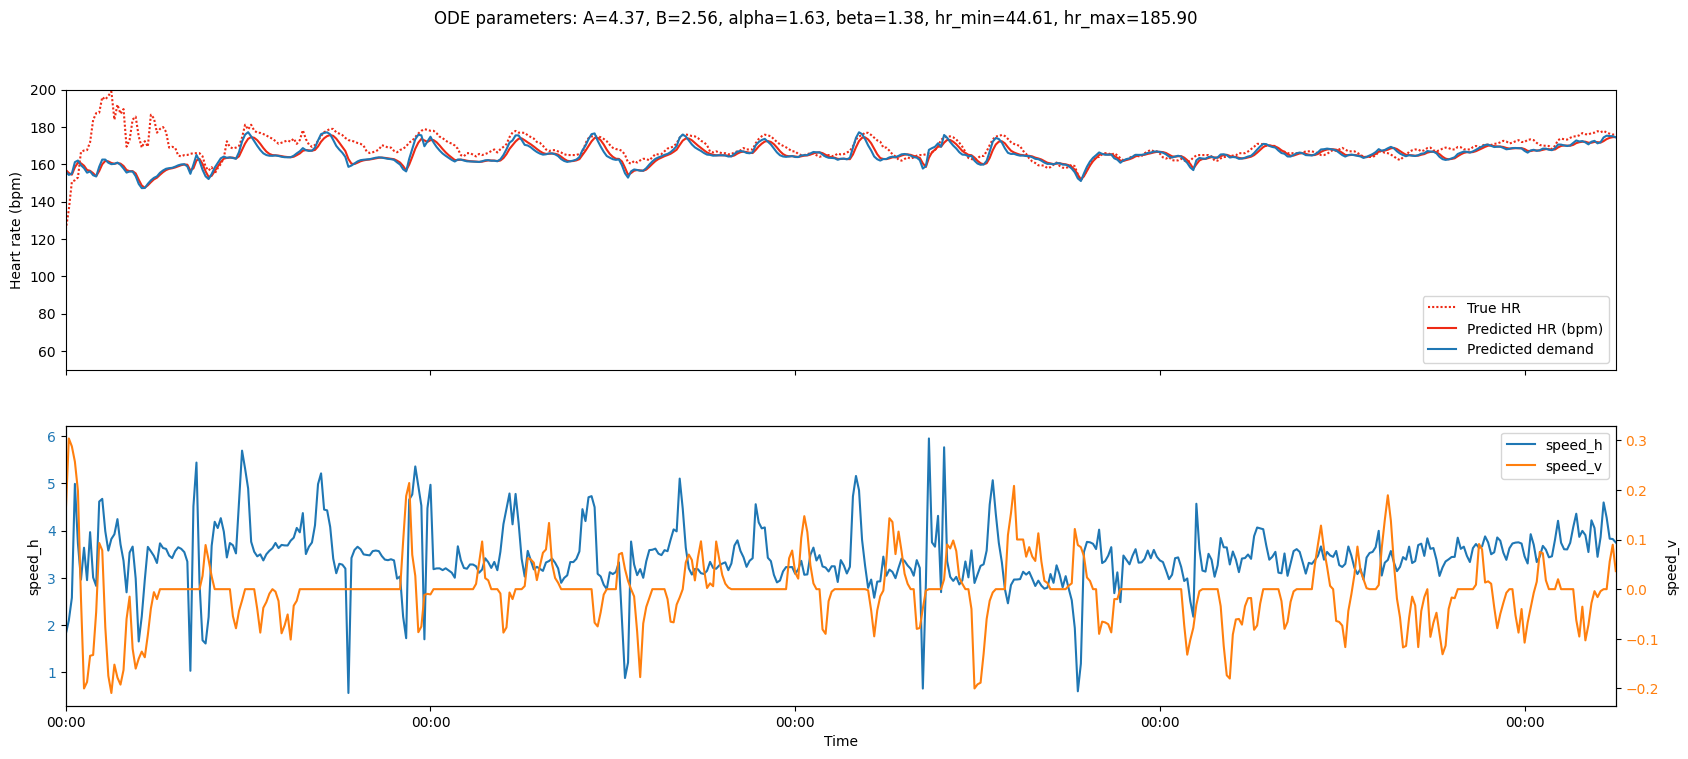

In [5]:
from examples.plotting import plot_workout_predictions

workout = test_dataset[10]
plot_workout_predictions(model, workout)